# Estimating large demand systems using jax

Jeremy Large and Emmet Hall-Hoffarth

In [1]:
import os 
import sys
# implement PYTHONPATH within script
sys.path.insert(0, os.path.abspath('../../lib'))

In [2]:
import logging
import warnings

In [3]:
import numpy as np
import pandas as pd
import pylab as plt
from sklearn import decomposition

In [4]:
warnings.simplefilter("ignore")
from rube.model.model import RubeJaxModel, load_params, positivize
import rube.data.clean

from rube.utils import nearest_neigbours
from rube.model.model import save_embeddings_tsv
from rube.data import uci

In [5]:
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, force=True)

### Background

We demonstrate code which can implement the algorithms in Lanier, Large and Quah (2022).

Whether online, in a supermarket, or elsewhere, people now assemble consumption bundles from an extremely wide variety of goods. This may be modeled as a discrete choice between bundles, to maximize a random utility depending on the unobserved attributes of the goods in the bundle.

Perhaps attributes may be orders-of-magnitude fewer than goods - much reducing the effective consumption space.

This code uses stochastic gradient descent across batched samples of a big dataset. Notwithstanding these features, it is intended to implement at scale a theory of consistent estimation which appears in Lanier, Large and Quah (2022). Thus it estimates every purchased good's latent attributes, jointly with every consumer's preferences over attributes.

This techniques has similarities to negative-sampling for word (and other) embedding in machine learning. The main way of running the code is in `/scripts/main.py`. However:

In [6]:
import jax
import jax.numpy as jnp

Move straight to the utility function of interest:

In [7]:
@jax.jit
def utility(raw_pars, q, p, u):
    '''
    :param raw_pars: Raw params of the qua model (A_, R, lb, ld_*)
    :param q: (negative_samples, stock_vocab_size) array of quantities
    :param p: (1, stock_vocab_size) array of prices
    :param u: (1,) vector containing a user_id, if no user data then it should be 0
    :return: (1, negative_samples) vector of utilities
    '''
    params = load_params(raw_pars)
    A = params['A']
    b = params['b'][:, u]
    d_1 = params['d_1'][:, u]
    d_2 = params['d_2'][:, u]
    d_3 = params['d_3'][:, u]

    a = jnp.dot(q, A)
    aa = jnp.diag(jnp.dot(a, a.T))
    ab = jnp.dot(a, b).T
    m = jnp.dot(p, q.T)[0]

    util = ab - aa - (d_1 * m) - (2 * d_3 * a[:, 0] * m)
    return util.T

### Load retail dataset from UCI

In [8]:
MAX_QUANTITY = 6
STOCK_VOCAB_SIZE = 2000
USER_VOCAB_SIZE = 2200
K = 12
BATCH_SIZE = 1024
NEGATIVE_SAMPLES = 99
STEP_SIZE = 0.01
SEED = 42

Load data:

In [9]:
gen = uci.UCIGenerator(BATCH_SIZE, NEGATIVE_SAMPLES,
                       max_accepted_quantity=MAX_QUANTITY,
                       stock_vocab_size=STOCK_VOCAB_SIZE,
                       user_vocab_size=USER_VOCAB_SIZE,
                       save_raw=True)

2022-02-19 13:29:10,711 INFO:Loading /home/jeremy/work/projects/opensource_RUBE/RUBE_data/uci_raw.csv , sheet Year 2009-2010
2022-02-19 13:29:14,948 INFO:Loaded /home/jeremy/work/projects/opensource_RUBE/RUBE_data/uci_raw.csv , sheet number one, obviously
2022-02-19 13:29:15,181 INFO:Of 509353 purchase records, removing 0 with infinite prices and 0 missing prices.
2022-02-19 13:29:15,254 INFO:Of 509353 purchase records, removing 0 with zero or -ve quantity/price.

2022-02-19 13:29:15,783 INFO:4227 separate stock codes were found in the dataset. On average each is mentioned 117 times.
2022-02-19 13:29:16,207 INFO:We observe 20577 separate invoices (baskets) costing on average $478.54 with 24 items.
2022-02-19 13:29:16,212 INFO:The most expensive invoice costs $49844.99. The biggest contains 673 items.
2022-02-19 13:29:16,259 INFO:Of 496204 purchase records, we remove 1791 which describe singleton baskets.
2022-02-19 13:29:16,531 INFO:Track the 2000 most frequent products, the least-view

Create a model:

In [10]:
model = RubeJaxModel(stock_vocab_size=len(gen.stock_vocab),
                     user_vocab_size=gen.user_vocab_size,
                     embedding_dim=K,
                     step_size=STEP_SIZE,
                     seed=SEED)

### Now fit the model

In [11]:
N_EPOCHS = 150   # 50 is a bit low - it is set this way for the sake of a manageable notebook

In [27]:
model.training_loop(gen, N_EPOCHS)

### Results

Obtain the model's fitted parameters (and remove unnecessary minus-signs):

In [13]:
params = positivize(load_params(model.params))

Now visualize `d_1`:

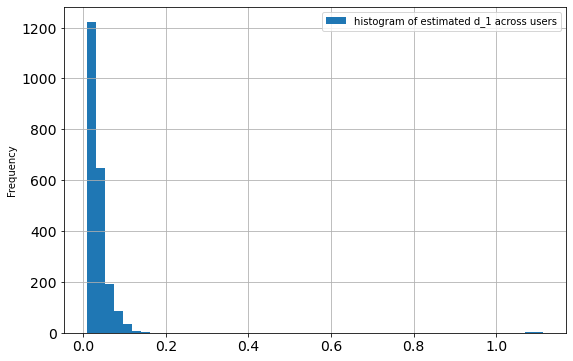

In [14]:
_ = pd.DataFrame(params['d_1'].T, columns=['histogram of estimated d_1 across users']).plot.hist(bins=50 , figsize=(9, 6), fontsize=14, grid=True)

Next look at `d_2`:

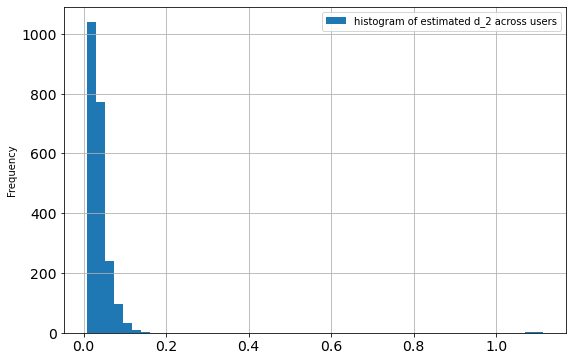

In [15]:
_ = pd.DataFrame(params['d_2'].T, columns=['histogram of estimated d_2 across users']).plot.hist(bins=50 , figsize=(9, 6), fontsize=14, grid=True)

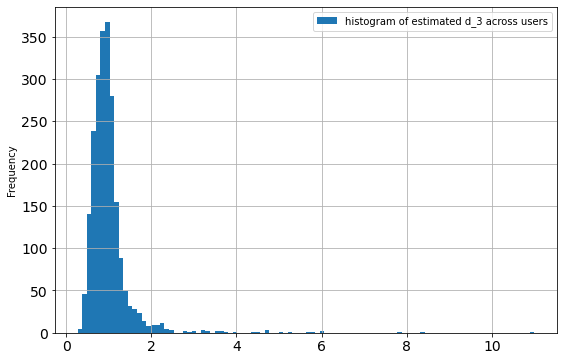

In [16]:
_ = pd.DataFrame(params['d_3'].T, columns=['histogram of estimated d_3 across users']).plot.hist(bins=100, grid=True, figsize=(9, 6), fontsize=14)

We can examine correlations in the `b` matrix recording user preferences across latent dimensions:

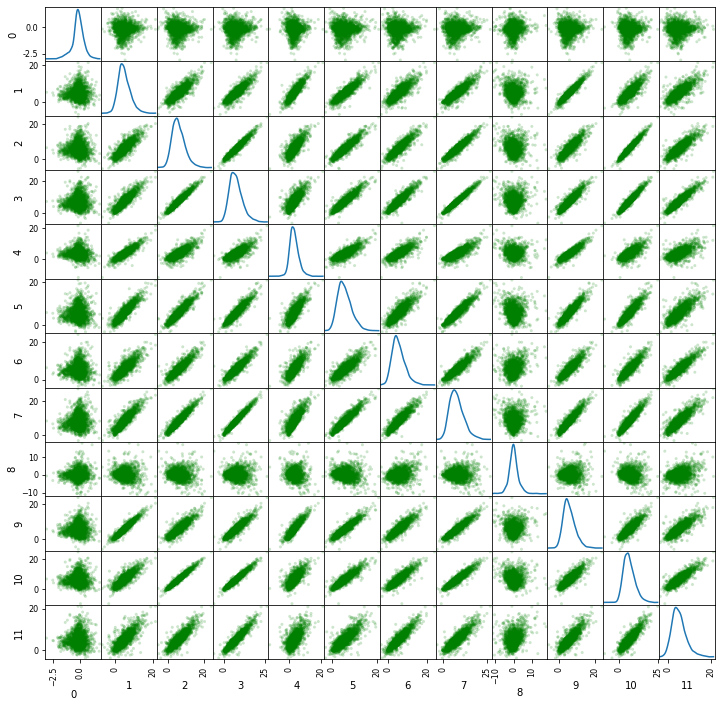

In [17]:
b = pd.DataFrame(params['b'])
_ = pd.plotting.scatter_matrix(b.T, alpha=0.2, figsize=(12, 12), color='g', diagonal="kde")

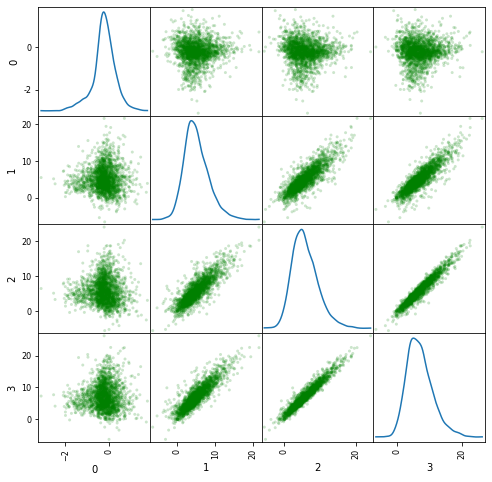

In [18]:
b = pd.DataFrame(params['b'])
_ = pd.plotting.scatter_matrix(b[:4].T, alpha=0.2, figsize=(8, 8), color='g', diagonal="kde")

We can also examine correlations in the `A` matrix, which records stock-items' features, across latent dimensions:

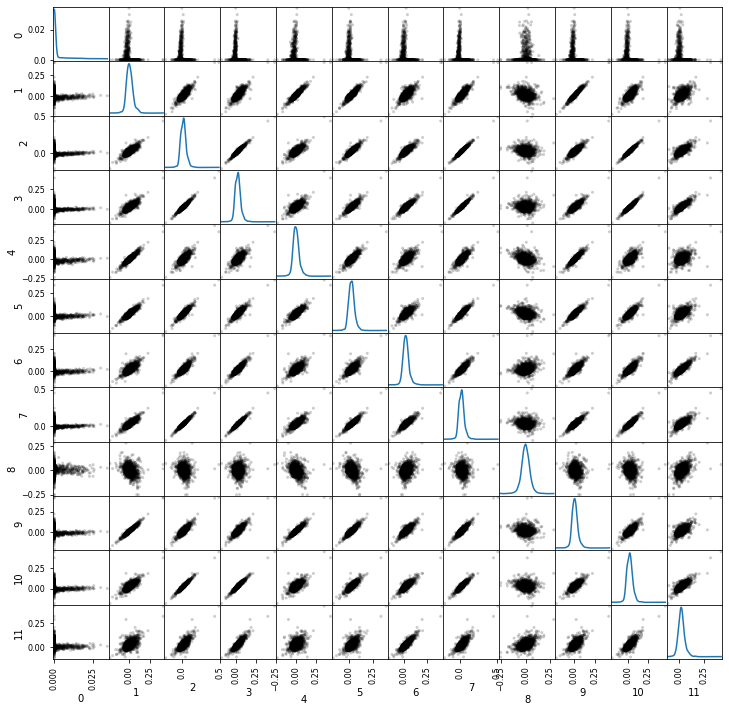

In [19]:
A = pd.DataFrame(params['A'])
_ = pd.plotting.scatter_matrix(A[:5000], alpha=0.2, figsize=(12, 12), color='k', diagonal="kde")

Note the special behaviour of the first dimension, along which values are constrained positive. This dimension has a particular interpretation that is related to price sensitivity.

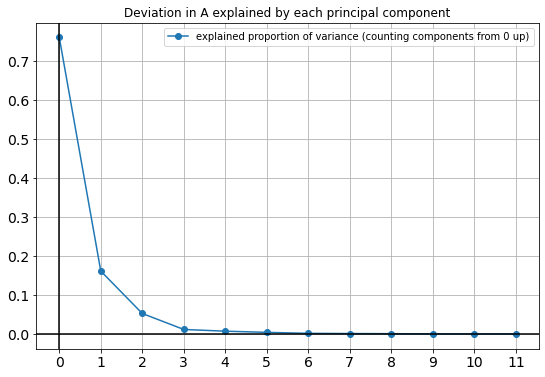

In [20]:
pca = decomposition.PCA(n_components=A.shape[1])
pca.fit(params['A'])
_title = 'Deviation in A explained by each principal component'
to_plot = pd.DataFrame((pca.explained_variance_ratio_), columns=['explained proportion of variance (counting components from 0 up)'])
_ = to_plot.plot(grid=True, title=_title, figsize=(9, 6), fontsize=14, marker='o', xticks=range(12))
plt.axhline(color='k'); _ = plt.axvline(color='k')

Save results for further assessments:

In [21]:
save_embeddings_tsv(params, gen)
vocab = pd.DataFrame(list(gen.stock_vocab), columns=['StockCode'])

### Price sensitivity

Lets do a simple-minded study of price sensitivities:

In [22]:
desc_lookup = gen.raw_data[['Description', 'product_token']].groupby('product_token').max()

In [26]:
sensitivities = vocab.join(pd.DataFrame(params['A'][:,0])).sort_values(0, ascending=False).join(desc_lookup)

Items where consumers exhibit the greatest price sensitivity:

In [24]:
sensitivities.head(10)

,StockCode,0,Description
1753,16011,0.034158,ANIMAL STICKERS
1700,17164B,0.029868,ASS COL SMALL SAND GECKO P'WEIGHT
1980,22984,0.025699,"CARD, GINGHAM ROSE"
1932,72232,0.025455,FENG SHUI PILLAR CANDLE
1495,17084N,0.025071,FAIRY DREAMS INCENSE
1260,16238,0.024969,PARTY TIME PENCIL ERASERS
1738,17033,0.024324,"BROCADE PURSE,SMALL ARCH BUTTON"
1940,16156N,0.023175,"WRAP, FRIENDSHIP ON GREEN"
1989,17096,0.023051,ASSORTED LAQUERED INCENSE HOLDERS
1119,16236,0.022707,KITTY PENCIL ERASERS


Items (drawn normally from quite a tightly-packed field) where consumers exhibit the least price sensitivity:

In [25]:
sensitivities.tail(10)

,StockCode,0,Description
1795,21740,0.000022,COSY SLIPPER SHOES LARGE RED
84,48187,0.000022,DOORMAT NEW ENGLAND
509,22468,0.000022,BABUSHKA LIGHTS STRING OF 10
208,22487,0.000021,WHITE WOOD GARDEN PLANT LADDER
1479,22796,0.000020,PHOTO FRAME 3 CLASSIC HANGING
224,22507,0.000020,MEMO BOARD RETROSPOT DESIGN
171,37503,0.000019,TEA TIME CAKE STAND IN GIFT BOX
1887,22511,0.000017,RETROSPOT BABUSHKA DOORSTOP
915,84078A,0.000017,SET/4 WHITE RETRO STORAGE CUBES
0,UNK,0.000000,ZINC TOP 2 DOOR WOODEN SHELF
